# Degridder Experiment - Analysis and Visualization

This notebook handles the analysis and visualization of the degridder experiment results.
It loads data generated by the `compilation_execution.ipynb` notebook and creates comprehensive graphs comparing Preesm and IARA performance.

## Analysis includes:
1. Binary size comparison
2. Scheduling time comparison  
3. Execution wall time comparison
4. Memory usage (max RSS) comparison
5. Combined performance visualizations

Make sure to run `compilation_execution.ipynb` first to generate the required data.

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Union
import matplotlib.axes
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load experiment directory and regenerate scenario data
experiment_dir = !realpath ~/repos/iara/experiment/degridder
experiment_dir = experiment_dir[0]

print(f"Loading experiment data from: {experiment_dir}/instances/")

# Recreate the scenario generation logic from the compilation notebook
grid_size = 5120
num_visibilities = 7848960

class Scenario:
  def __init__(self, name: str, num_cores: int, num_chunks: int, num_supports: int, grid_size: int, num_visibilities: int):
    self.name = name
    self.instance_path = f"{experiment_dir}/instances/{name}"
    self.iara_bin_path = None
    self.preesm_bin_path = None
    self.iara_scheduling_time = None
    self.preesm_scheduling_time = None
    self.srdag_edges = None
    self.srdag_nodes = None
    self.preesm_bin_size = None
    self.iara_bin_size = None
    self.num_cores = num_cores
    self.num_supports = num_supports
    self.num_chunks = num_chunks
    self.num_visibilities = num_visibilities
    self.grid_size = grid_size
    self.dataset_size = "large"
    # Execution performance data
    self.preesm_wall_time = None
    self.preesm_max_rss = None
    self.iara_wall_time = None
    self.iara_max_rss = None
    # Exit codes for compilation and execution
    self.preesm_compilation_exit_code = None
    self.iara_compilation_exit_code = None
    self.preesm_execution_exit_code = None
    self.iara_execution_exit_code = None
    # Memory sections
    self.preesm_text_size = None
    self.preesm_data_size = None
    self.preesm_bss_size = None
    self.iara_text_size = None
    self.iara_data_size = None
    self.iara_bss_size = None

# Recreate the scenario list by scanning the instances directory
import glob
instance_dirs = glob.glob(f"{experiment_dir}/instances/generated_large_*")
all_ordered_scenarios = []

print(instance_dirs)

for instance_dir in instance_dirs:
    scenario_name = os.path.basename(instance_dir)
    # Parse the scenario name to extract parameters
    # Format: generated_large_{num_cores}cores_{num_chunks}chunks_{num_supports}supports.scenario
    parts = scenario_name.replace('.scenario', '').split('_')

    try:
        num_cores = int(parts[2].replace('cores', ''))
        num_chunks = int(parts[3].replace('chunks', ''))
        num_supports = int(parts[4].replace('supports', ''))
        scenario = Scenario(scenario_name, num_cores, num_chunks, num_supports, grid_size, num_visibilities)
        all_ordered_scenarios.append(scenario)
    except ValueError:
        print(f"Warning: Could not parse scenario name: {scenario_name}")

print(f"Found {len(all_ordered_scenarios)} scenarios from instance directories")

Loading experiment data from: /home/jabcross/repos/iara/experiment/degridder/instances/
['/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_1chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_2chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_4chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_8chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_16chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_32chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_64chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_128chunks_8supports.scenario', '/home/jabcross/repos/iara

In [80]:
# Read all experiment data from files
import re

def parse_time_file(file_path):
    """Parse /usr/bin/time -v output to extract wall time, max RSS, and exit status"""
    try:
        with open(file_path, 'r') as f:
            content = f.read()
        
        # Extract wall clock time (format: h:mm:ss or mm:ss.ss)
        wall_time_match = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (.+)', content)
        wall_time_seconds = None
        if wall_time_match:
            time_str = wall_time_match.group(1).strip()
            if ':' in time_str:
                parts = time_str.split(':')
                if len(parts) == 3:  # h:mm:ss
                    hours, minutes, seconds = parts
                    wall_time_seconds = float(hours) * 3600 + float(minutes) * 60 + float(seconds)
                elif len(parts) == 2:  # mm:ss
                    minutes, seconds = parts
                    wall_time_seconds = float(minutes) * 60 + float(seconds)
            else:
                wall_time_seconds = float(time_str)
        
        # Extract maximum resident set size (in KB)
        max_rss_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', content)
        max_rss_kb = int(max_rss_match.group(1)) if max_rss_match else None
        
        # If the process was killed by a signal (e.g., segfault), check for "Command terminated by signal"
        signal_match = re.search(r'Command terminated by signal (\d+)', content)
        if signal_match:
            exit_status = int(signal_match.group(1))
        else:
            # Extract exit status
            exit_status_match = re.search(r'Exit status: (\d+)', content)
            exit_status = int(exit_status_match.group(1)) if exit_status_match else None
        
        return wall_time_seconds, max_rss_kb, exit_status
    except FileNotFoundError:
        return None, None, None
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None, None, None

# Read compilation data from Preesm
print("Reading Preesm compilation data...")
for scenario in all_ordered_scenarios:
    # Read binary size
    scenario.preesm_bin_path = f'{experiment_dir}/instances/{scenario.name}/preesm_build/degridder_pipeline'
    if os.path.exists(scenario.preesm_bin_path):
        scenario.preesm_bin_size = os.path.getsize(scenario.preesm_bin_path)
        
        # Read scheduling time and compilation exit code
        scheduling_time_file = f'{experiment_dir}/instances/{scenario.name}/preesm_build/measurements/scheduling_time.txt'
        if os.path.exists(scheduling_time_file):
            try:
                walltime_str = !grep "wall clock" '{scheduling_time_file}' | cut -f 8 -d ' '
                if walltime_str:
                    time_str = walltime_str[0].strip()
                    minutes, seconds = time_str.split(':')
                    scenario.preesm_scheduling_time = float(minutes) * 60 + float(seconds)
                
                # Extract compilation exit code
                exit_code_str = !grep "Exit status:" '{scheduling_time_file}' | cut -f 3 -d ' '
                if exit_code_str:
                    scenario.preesm_compilation_exit_code = int(exit_code_str[0].strip())
            except:
                scenario.preesm_scheduling_time = None
                scenario.preesm_compilation_exit_code = None

    # Read SRDAG information
    preesm_stdout_file = f'{experiment_dir}/instances/{scenario.name}/preesm_build/measurements/stdout.txt'
    if os.path.exists(preesm_stdout_file):
        try:
            srdag_output = !grep "SRDAG" '{preesm_stdout_file}'
            if srdag_output and len(srdag_output) > 0:
                match = re.search(r'SRDAG with (\d+) vertices and (\d+) edges', srdag_output[0])
                if match:
                    scenario.srdag_nodes = int(match.group(1))
                    scenario.srdag_edges = int(match.group(2))
        except:
            pass

# Read compilation data from IARA
print("Reading IARA compilation data...")
for scenario in all_ordered_scenarios:
    # Read binary size
    scenario.iara_bin_path = f'{experiment_dir}/instances/{scenario.name}/build/degridder_pipeline'
    if os.path.exists(scenario.iara_bin_path):
        scenario.iara_bin_size = os.path.getsize(scenario.iara_bin_path)
        
        # Read scheduling time and compilation exit code
        scheduling_time_file = f'{experiment_dir}/instances/{scenario.name}/build/measurements/scheduling_time.txt'
        if os.path.exists(scheduling_time_file):
            try:
                walltime_str = !grep "wall clock" '{scheduling_time_file}' | cut -f 8 -d ' '
                if walltime_str:
                    time_str = walltime_str[0].strip()
                    minutes, seconds = time_str.split(':')
                    scenario.iara_scheduling_time = float(minutes) * 60 + float(seconds)
                
                # Extract compilation exit code
                exit_code_str = !grep "Exit status:" '{scheduling_time_file}' | cut -f 3 -d ' '
                if exit_code_str:
                    scenario.iara_compilation_exit_code = int(exit_code_str[0].strip())
            except:
                scenario.iara_scheduling_time = None
                scenario.iara_compilation_exit_code = None

# Read execution performance data
print("Reading execution performance data...")
for scenario in all_ordered_scenarios:
    # Parse Preesm execution data
    preesm_time_file = f'{experiment_dir}/instances/{scenario.name}/preesm_build/measurements/degridder_time_0.txt'
    scenario.preesm_wall_time, scenario.preesm_max_rss, scenario.preesm_execution_exit_code = parse_time_file(preesm_time_file)
    if scenario.preesm_max_rss is not None:
        scenario.preesm_max_rss *= 1024
    
    # Parse IARA execution data
    iara_time_file = f'{experiment_dir}/instances/{scenario.name}/build/measurements/degridder_time_0.txt'
    scenario.iara_wall_time, scenario.iara_max_rss, scenario.iara_execution_exit_code = parse_time_file(iara_time_file)
    if scenario.iara_max_rss is not None:
        scenario.iara_max_rss *= 1024

print(f"Data loading complete!")
print(f"Scenarios with Preesm compilation: {sum(1 for s in all_ordered_scenarios if s.preesm_bin_size)}")
print(f"Scenarios with IARA compilation: {sum(1 for s in all_ordered_scenarios if s.iara_bin_size)}")
print(f"Scenarios with SRDAG data: {sum(1 for s in all_ordered_scenarios if s.srdag_edges)}")
print(f"Scenarios with Preesm execution data: {sum(1 for s in all_ordered_scenarios if s.preesm_wall_time)}")
print(f"Scenarios with IARA execution data: {sum(1 for s in all_ordered_scenarios if s.iara_wall_time)}")

Reading Preesm compilation data...


Reading IARA compilation data...
Reading execution performance data...
Data loading complete!
Scenarios with Preesm compilation: 45
Scenarios with IARA compilation: 55
Scenarios with SRDAG data: 55
Scenarios with Preesm execution data: 40
Scenarios with IARA execution data: 55
Reading execution performance data...
Data loading complete!
Scenarios with Preesm compilation: 45
Scenarios with IARA compilation: 55
Scenarios with SRDAG data: 55
Scenarios with Preesm execution data: 40
Scenarios with IARA execution data: 55


In [81]:
import subprocess

def get_static_memory_allocation(binary_path):
    """Extract memory section sizes from binary using size command"""
    if not os.path.exists(binary_path):
        return None, None, None
    
    try:
        # Use size command to get section sizes
        result = subprocess.run(['size', binary_path], 
                              capture_output=True, text=True, check=True)
        
        # Parse size output format:
        # text    data     bss     dec     hex filename
        lines = result.stdout.strip().split('\n')
        if len(lines) >= 2:  # Header + data line
            data_line = lines[1].split()
            if len(data_line) >= 3:
                text_size = int(data_line[0])
                data_size = int(data_line[1])
                bss_size = int(data_line[2])
                return text_size, data_size, bss_size
        
        return None, None, None
    except (subprocess.CalledProcessError, FileNotFoundError, ValueError) as e:
        print(f"Error analyzing {binary_path}: {e}")
        return None, None, None

def get_static_memory_allocation_objdump(binary_path):
    """Extract memory section sizes using objdump for detailed breakdown"""
    if not os.path.exists(binary_path):
        return None, None, None
    
    try:
        result = subprocess.run(['objdump', '-h', binary_path], 
                              capture_output=True, text=True, check=True)
        
        text_size = 0
        data_size = 0 
        bss_size = 0
        
        for line in result.stdout.split('\n'):
            if '.text' in line:
                parts = line.split()
                if len(parts) >= 3:
                    text_size = int(parts[2], 16)  # Size is in hex
            elif '.data' in line and '.data.' not in line:  # Avoid .data.rel.ro etc.
                parts = line.split()
                if len(parts) >= 3:
                    data_size += int(parts[2], 16)
            elif '.rodata' in line:
                parts = line.split()
                if len(parts) >= 3:
                    data_size += int(parts[2], 16)  # Add rodata to data
            elif '.bss' in line:
                parts = line.split()
                if len(parts) >= 3:
                    bss_size += int(parts[2], 16)
                    
        return text_size, data_size, bss_size
        
    except (subprocess.CalledProcessError, ValueError) as e:
        print(f"Error extracting memory info from {binary_path}: {e}")
        return None, None, None

In [82]:
# Extract static memory allocation from binaries
print("Extracting memory section data...")
for scenario in all_ordered_scenarios:
    # Extract Preesm memory sections
    if scenario.preesm_bin_path and os.path.exists(scenario.preesm_bin_path):
        scenario.preesm_text_size, scenario.preesm_data_size, scenario.preesm_bss_size = get_static_memory_allocation(scenario.preesm_bin_path)
    else:
        scenario.preesm_text_size = scenario.preesm_data_size = scenario.preesm_bss_size = None
    
    # Extract IARA memory sections
    if scenario.iara_bin_path and os.path.exists(scenario.iara_bin_path):
        scenario.iara_text_size, scenario.iara_data_size, scenario.iara_bss_size = get_static_memory_allocation(scenario.iara_bin_path)
    else:
        scenario.iara_text_size = scenario.iara_data_size = scenario.iara_bss_size = None

# Extract detailed memory sections for stacked chart using objdump
print("Extracting detailed memory section data for stacked chart...")
for scenario in all_ordered_scenarios:
    # Extract Preesm detailed memory sections
    if scenario.preesm_bin_path and os.path.exists(scenario.preesm_bin_path):
        scenario.preesm_text_detailed, scenario.preesm_data_detailed, scenario.preesm_bss_detailed = get_static_memory_allocation_objdump(scenario.preesm_bin_path)
    else:
        scenario.preesm_text_detailed = scenario.preesm_data_detailed = scenario.preesm_bss_detailed = None
    
    # Extract IARA detailed memory sections
    if scenario.iara_bin_path and os.path.exists(scenario.iara_bin_path):
        scenario.iara_text_detailed, scenario.iara_data_detailed, scenario.iara_bss_detailed = get_static_memory_allocation_objdump(scenario.iara_bin_path)
    else:
        scenario.iara_text_detailed = scenario.iara_data_detailed = scenario.iara_bss_detailed = None

print(f"Memory section extraction complete!")
print(f"Scenarios with Preesm memory data: {sum(1 for s in all_ordered_scenarios if s.preesm_text_size is not None)}")
print(f"Scenarios with IARA memory data: {sum(1 for s in all_ordered_scenarios if s.iara_text_size is not None)}")

Extracting memory section data...
Extracting detailed memory section data for stacked chart...
Memory section extraction complete!
Scenarios with Preesm memory data: 45
Scenarios with IARA memory data: 55
Memory section extraction complete!
Scenarios with Preesm memory data: 45
Scenarios with IARA memory data: 55


In [83]:
# Filter and prepare scenarios for analysis

# Don't filter out scenarios - show all scenarios including those without SRDAG data
scenario_list = all_ordered_scenarios
scenario_list.sort(key=lambda s: (s.num_chunks, s.num_cores if s.srdag_edges is not None else 9999999999))

print(f"Using all {len(scenario_list)} scenarios for analysis (including those without SRDAG data)")
print(f"Scenarios with SRDAG data: {sum(1 for s in scenario_list if s.srdag_edges is not None)}")
print(f"Scenarios without SRDAG data: {sum(1 for s in scenario_list if s.srdag_edges is None)}")

Using all 55 scenarios for analysis (including those without SRDAG data)
Scenarios with SRDAG data: 55
Scenarios without SRDAG data: 0


In [84]:
# Helper functions for plotting to reduce code repetition
import matplotlib.ticker as ticker

def format_bytes(x, pos):
    return x

def get_smallest_unit_and_formatter(data_values):
    """Determine the smallest appropriate unit for a dataset and return formatter"""
    # Filter out None values and find the maximum value
    real_values = [v for v in data_values if v is not None]
    if not real_values:
        return "B", lambda x, pos: f'{int(x):,}'
    
    max_val = max(real_values)
    
    if max_val < 1024:
        return "B", lambda x, pos: f'{int(x):,}'
    elif max_val < 1024**2:
        return "KB", lambda x, pos: f'{x/1024:,.0f}'
    elif max_val < 1024**3:
        return "MB", lambda x, pos: f'{x/(1024**2):,.1f}'
    else:
        return "GB", lambda x, pos: f'{x/(1024**3):,.1f}'

def format_number_with_commas(x, pos):
    """General formatter for numeric values with thousands separators"""
    if x == 0:
        return '0'
    elif x >= 1000:
        return f'{x:,.0f}'
    elif x >= 1:
        return f'{x:.1f}'
    else:
        return f'{x:.2f}'

def add_timeout_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]], bar_width_offset: float = 0) -> float:
    """Add 'Timeout' labels for None values in the data and return their height in graph units"""
    timeout_height_in_graph_units = 0

    for idx, val in enumerate(values):
        if val is None:
            # Add the timeout label
            text_obj = ax.text(x_positions[idx] + bar_width_offset, 0.5, 'Timeout',
                               ha='center', va='bottom', color='red', rotation=90)

            # Calculate the height of the rotated text in graph units
            # For a 90-degree rotated text, the height becomes the width in graph coordinates
            renderer = ax.figure.canvas.get_renderer()
            bbox = text_obj.get_window_extent(renderer=renderer)

            # Transform from display coordinates to data coordinates
            bbox_data = bbox.transformed(ax.transData.inverted())

            # For rotated text (90 degrees), width in display becomes height in graph
            text_width_in_data = bbox_data.height
            # This is the "height" of rotated text
            text_height_in_graph = text_width_in_data

            timeout_height_in_graph_units = max(
                timeout_height_in_graph_units, text_height_in_graph + 0.5)

    return timeout_height_in_graph_units


def add_edge_count_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                          srdag_edges: List[Optional[int]], offset_percentage: float = 0.05,
                          timeout_height: float = 0) -> None:
    """Add edge count labels above bars, with offset relative to graph scale"""
    # Calculate offset based on the current y-axis range
    y_min, y_max = ax.get_ylim()
    graph_scale_offset = (y_max - y_min) * offset_percentage

    for idx, edge_count in enumerate(srdag_edges):
        if edge_count is not None:
            max_height = values[idx] if values[idx] is not None else 0
            max_height = max(max_height, (timeout_height *1.1) if values[idx] is None else 0)

            y_position = max_height + graph_scale_offset

            ax.text(x_positions[idx], y_position,
                    f"#edges:\n{edge_count}",
                    ha='center', va='bottom', fontsize=8, color='black')


def setup_bar_plot(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                   bar_width: float, color_map: List[str],
                   ylabel: str, xlabel: str, title: str, scenario_names: List[str]) -> matplotlib.container.BarContainer:
    """Setup a basic bar plot with common formatting"""
    bars = ax.bar(x_positions, [v if v is not None else 0 for v in values],
                  bar_width, color=color_map)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(scenario_names, rotation=90)
    return bars


def set_ylim_with_padding(ax: matplotlib.axes.Axes, values: List[Optional[float]],
                          padding_factor: float = 1.2, min_timeout_space: float = 20.0) -> None:
    """Set y-axis limits with padding to accommodate labels and timeout scenarios"""
    max_val = max([v for v in values if v is not None], default=0)
    if max_val > 0:
        ax.set_ylim(0, max_val * padding_factor)
    else:
        # If all values are None (timeouts), ensure enough space for labels
        ax.set_ylim(0, min_timeout_space)

print("Helper functions loaded successfully")

Helper functions loaded successfully


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 15, 15, 15, 15]
1
-0.5
44.5
1
-0.5
44.5
1
-0.5
44.5
1
-0.5
44.5
1
-0.5
44.5
data_area_start_n: 0.04240390482001221
data_area_end_n: 0.9575960951799878
bar_width_n: 0.07291031116534473
data_area_start_n: 0.04240390482001221
data_area_end_n: 0.9575960951799878
bar_width_n: 0.07291031116534473


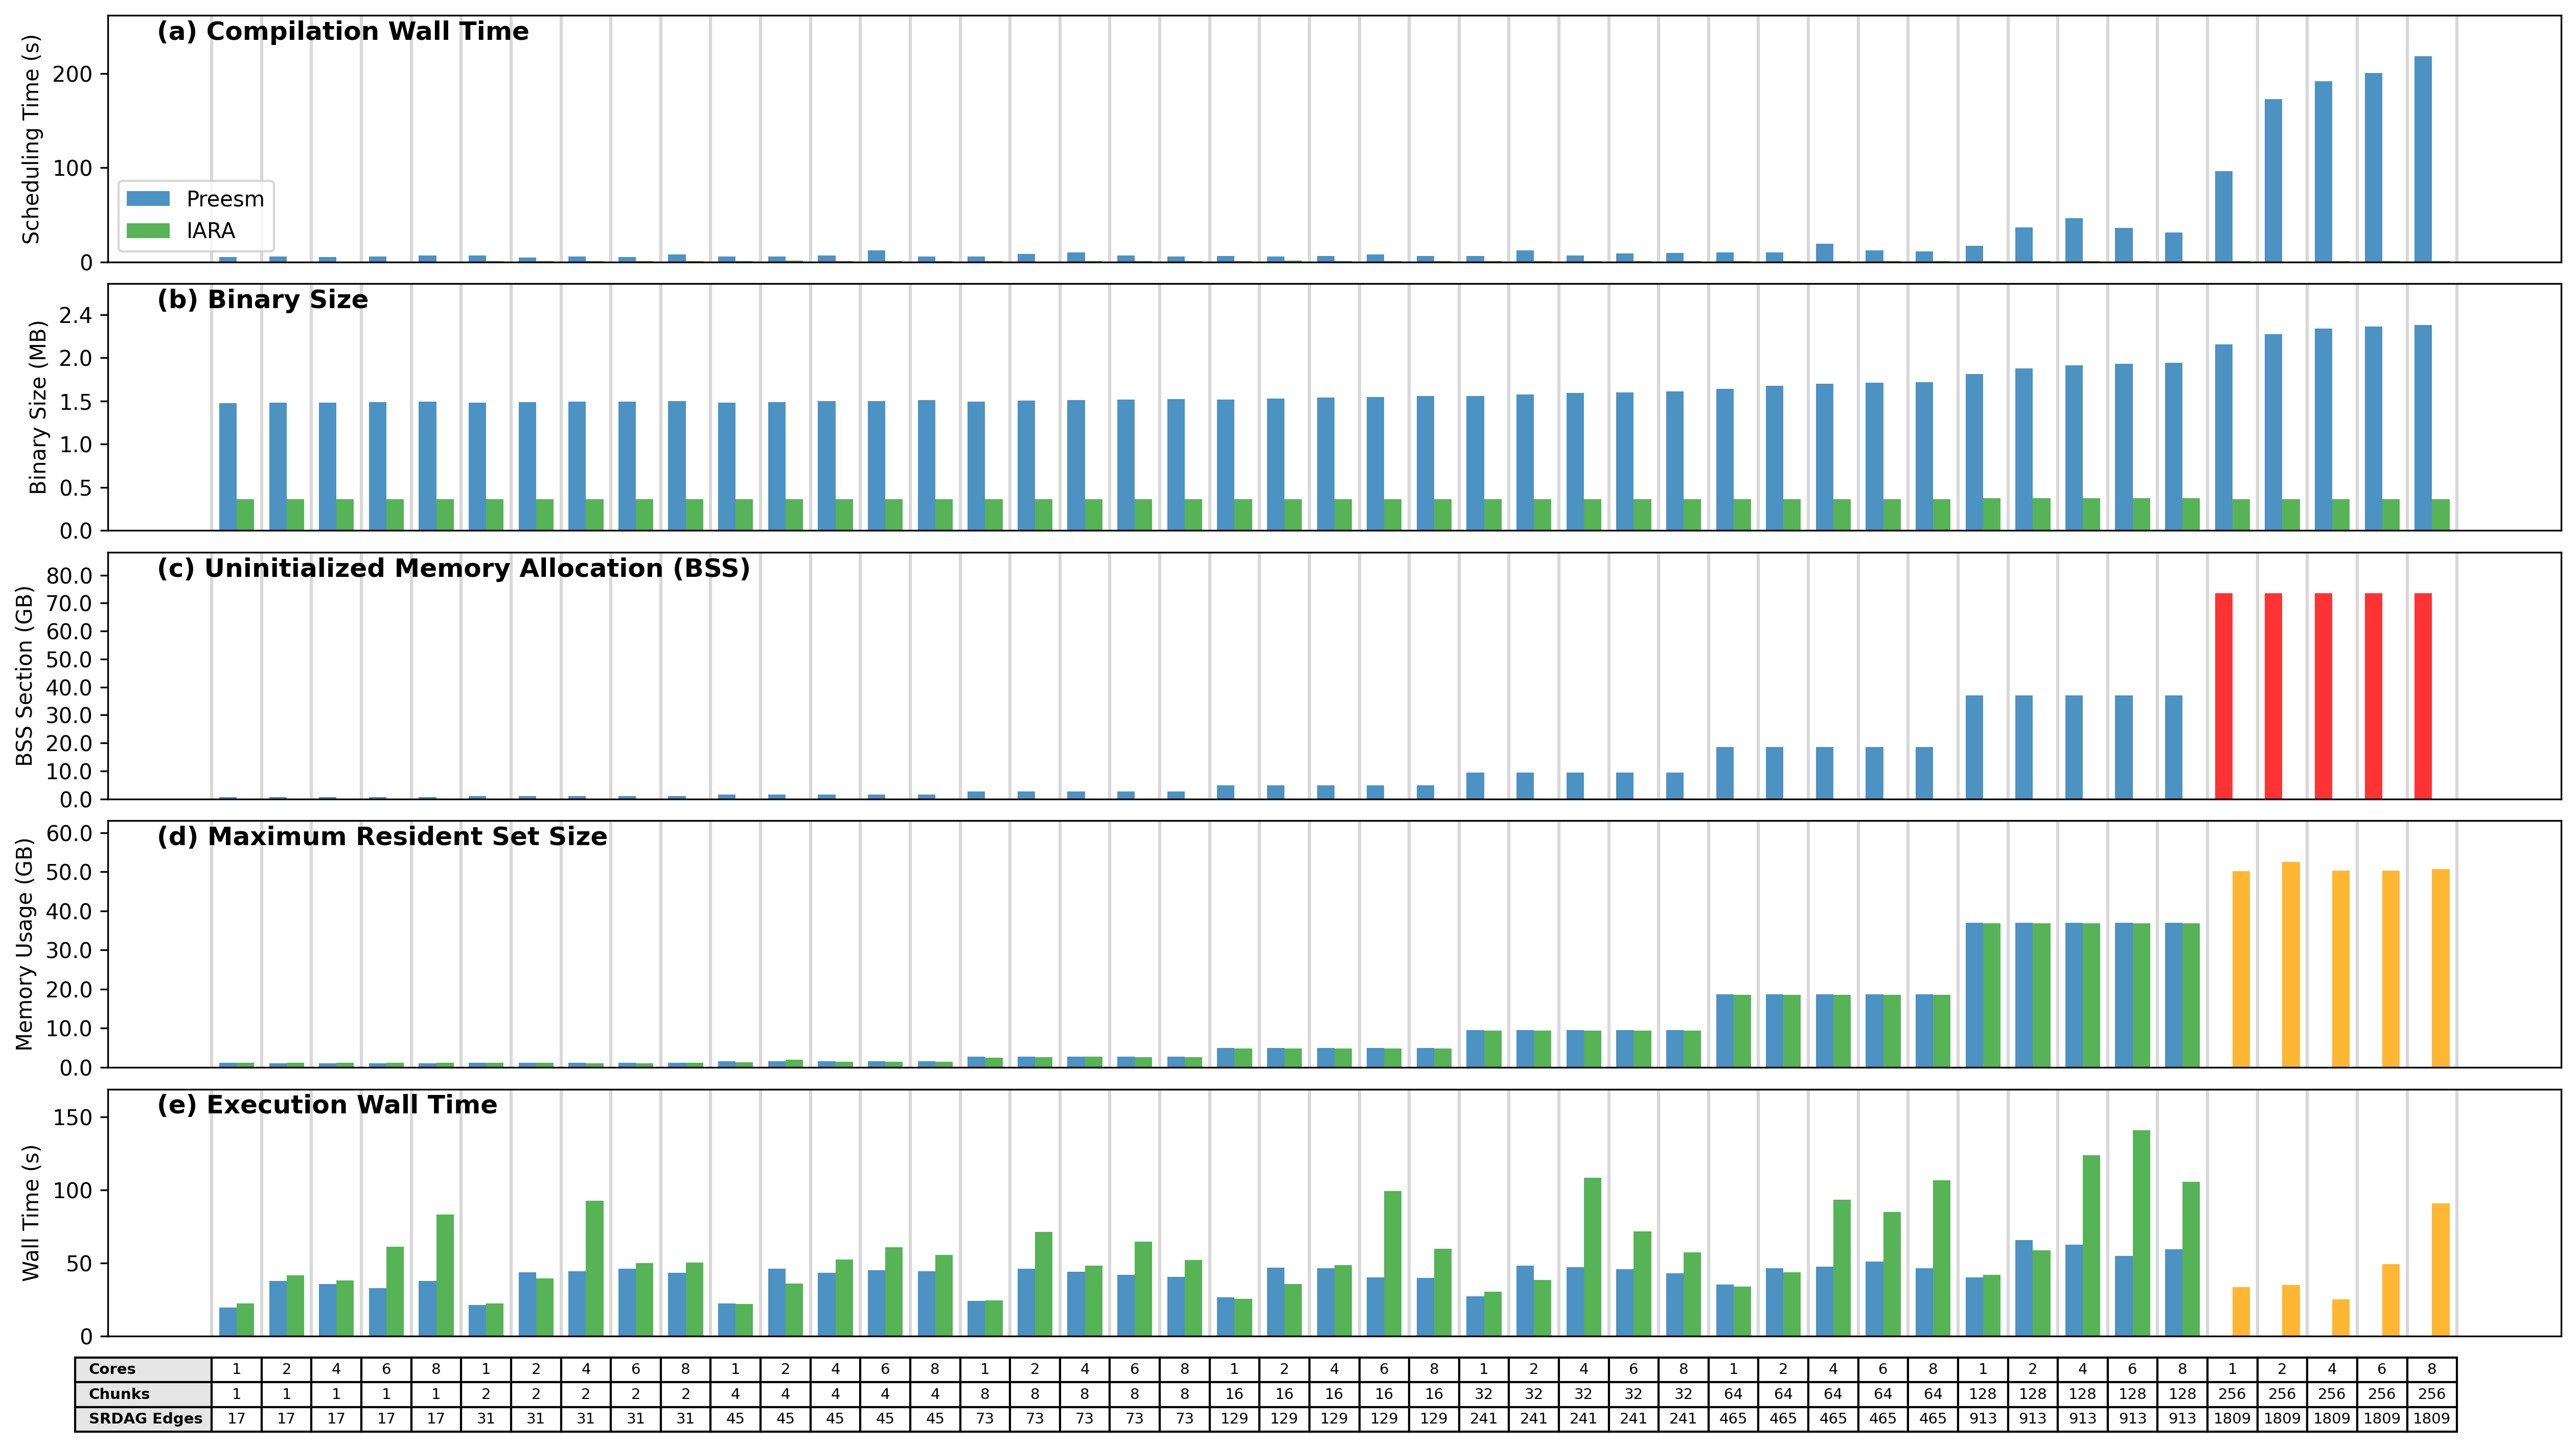

In [85]:
# Combined Vertical Layout - All Performance Metrics
from typing import List, Optional, Any
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.container
import matplotlib.figure
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import numpy as np

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig: matplotlib.figure.Figure = plt.figure(figsize=(16, 12), dpi=300)

# Create gridspec with height ratios - table should be half the height of each graph
# Set zero padding to let graphs touch since we're manually aligning horizontally
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 1, 1, 1, 1, 0.3], hspace=0.1)

ax1: matplotlib.axes.Axes = fig.add_subplot(gs[0])
ax2: matplotlib.axes.Axes = fig.add_subplot(gs[1])
ax3: matplotlib.axes.Axes = fig.add_subplot(gs[2])
ax4: matplotlib.axes.Axes = fig.add_subplot(gs[3])
ax5: matplotlib.axes.Axes = fig.add_subplot(gs[4])

scenario_list = scenario_list[:-10]

# Prepare data for plotting in the same order as scenario_list
scenario_names = [s.name for s in scenario_list]
preesm_sizes = [s.preesm_bin_size for s in scenario_list]
iara_sizes = [s.iara_bin_size for s in scenario_list]
srdag_edges = [s.srdag_edges for s in scenario_list]
preesm_times = [s.preesm_scheduling_time for s in scenario_list]
# preesm_times = [0 for s in scenario_list]
iara_times = [s.iara_scheduling_time for s in scenario_list]
preesm_wall_times = [s.preesm_wall_time for s in scenario_list]
iara_wall_times = [s.iara_wall_time for s in scenario_list]
preesm_max_rss = [s.preesm_max_rss for s in scenario_list]
iara_max_rss = [s.iara_max_rss for s in scenario_list]
# Memory sections for stacked bars
preesm_text_sizes = [s.preesm_text_size for s in scenario_list]
preesm_data_sizes = [s.preesm_data_size for s in scenario_list]
preesm_bss_sizes = [s.preesm_bss_size for s in scenario_list]
iara_text_sizes = [s.iara_text_size for s in scenario_list]
iara_data_sizes = [s.iara_data_size for s in scenario_list]
iara_bss_sizes = [s.iara_bss_size for s in scenario_list]

# Detailed memory sections for stacked chart (objdump-based)
preesm_text_detailed = [s.preesm_text_detailed for s in scenario_list]
preesm_data_detailed = [s.preesm_data_detailed for s in scenario_list]
preesm_bss_detailed = [s.preesm_bss_detailed for s in scenario_list]
iara_text_detailed = [s.iara_text_detailed for s in scenario_list]
iara_data_detailed = [s.iara_data_detailed for s in scenario_list]
iara_bss_detailed = [s.iara_bss_detailed for s in scenario_list]

# Convert BSS sizes to GB for proper chart scaling
preesm_bss_gb = [v / (1024**3) if v is not None else None for v in preesm_bss_sizes]
iara_bss_gb = [v / (1024**3) if v is not None else None for v in iara_bss_sizes]

# Prepare exit code data
preesm_compilation_exit_codes = [s.preesm_compilation_exit_code for s in scenario_list]
iara_compilation_exit_codes = [s.iara_compilation_exit_code for s in scenario_list]
preesm_execution_exit_codes = [s.preesm_execution_exit_code for s in scenario_list]
iara_execution_exit_codes = [s.iara_execution_exit_code for s in scenario_list]
print(iara_execution_exit_codes)

x = np.arange(len(scenario_names))
width = 0.35



def create_subplot_bars(ax: matplotlib.axes.Axes, 
                       preesm_data: List[Optional[float]], 
                       iara_data: List[Optional[float]], 
                       preesm_exit_codes: List[Optional[int]],
                       iara_exit_codes: List[Optional[int]],
                       missing_height: float, 
                       ylabel: str, 
                       title: str, 
                       show_xlabel: bool = False,
                       show_legend: bool = True,
                       formatter = None) -> None:

    """Helper function to create bars for a subplot with consistent styling"""
    # Create color maps based on data availability and exit codes
    preesm_colors: List[str] = []
    iara_colors: List[str] = []
    
    for i, (val, exit_code) in enumerate(zip(preesm_data, preesm_exit_codes)):
        if val is None:
            preesm_colors.append('tab:red')  # No data available
        elif exit_code is not None and exit_code != 0:
            preesm_colors.append('red')  # Failed execution (non-zero exit code)
        else:
            preesm_colors.append('tab:blue')  # Successful execution
    
    for i, (val, exit_code) in enumerate(zip(iara_data, iara_exit_codes)):
        if val is None:
            iara_colors.append('tab:red')  # No data available
        elif exit_code is not None and exit_code != 0:
            iara_colors.append('orange')  # Failed execution (non-zero exit code)
        else:
            iara_colors.append('tab:green')  # Successful execution


    # Create bars
    bars_preesm: matplotlib.container.BarContainer = ax.bar(
        x - width/2, [val if val is not None else 0 for val in preesm_data],
        width, label='Preesm', color=preesm_colors, alpha=0.8)
    bars_iara: matplotlib.container.BarContainer = ax.bar(
        x + width/2, [val if val is not None else 0 for val in iara_data],
        width, label='IARA', color=iara_colors, alpha=0.8)

# Initialize global variables for table positioning
    global data_area_start
    global data_area_start_n
    global data_area_end_n
    global bar_width_n

    full_width: float = ax.get_xlim()[1]
    bar_width: float = x[1] - x[0]
    data_area_start = x[0] - bar_width / 2
    data_area_end: float = x[-1] + bar_width / 2
    print(bar_width)
    print(data_area_start)
    print(data_area_end)
    graph_l = 0
    graph_r = full_width


    # Get x-axis range for normalization
    x_min, x_max = ax.get_xlim()
    
    def normalize(x_val: float) -> float: 
        return (x_val - x_min) / (x_max - x_min)

    # ax.axvline(data_area_end, 0, 1)
    # ax.axvline(data_area_start, 0 , 1)

    graph_l_n = normalize(graph_l)
    bar_width_n = normalize(bar_width)
    graph_r_n = normalize(graph_r)
    data_area_start_n = normalize(data_area_start)
    data_area_end_n = normalize(data_area_end)

    # Set labels and legend
    ax.set_ylabel(ylabel)
    if show_legend:
        ax.legend()

    # Get appropriate unit and create custom formatter
    if ylabel == 'Binary Size':
        unit, custom_formatter = get_smallest_unit_and_formatter(preesm_data + iara_data)
        ax.set_ylabel(f'{ylabel} ({unit})')
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        # Set tick marks every 200 KB for binary size
        ax.yaxis.set_major_locator(ticker.MultipleLocator(500 * 1024))
    elif ylabel == 'Memory Usage':
        unit, custom_formatter = get_smallest_unit_and_formatter(preesm_data + iara_data)
        ax.set_ylabel(f'{ylabel} ({unit})')
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        # Set tick marks every 10 MB for memory usage
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10 * 1024 * 1024 * 1024))
    elif ylabel == 'BSS Section':
        unit, custom_formatter = get_smallest_unit_and_formatter(preesm_data + iara_data)
        ax.set_ylabel(f'{ylabel} ({unit})')
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        # Set tick marks every 1 GB for BSS
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10 *  1024* 1024 * 1024))


    # Add title inside the plot at top left corner
    ax.text(0.02, 0.98, title, transform=ax.transAxes, fontsize=12, fontweight='bold',
            verticalalignment='top', horizontalalignment='left')

    # Handle x-axis labels and tick marks
    if show_xlabel:
        ax.set_xlabel('Scenario')
        ax.set_xticks([])  # Remove x-axis tick marks
        ax.set_xticklabels([])  # Hide x-axis labels - replaced by table below
    else:
        ax.set_xticks([])  # Remove x-axis tick marks
        ax.set_xticklabels([])  # Hide x-axis labels

    # Set y-axis limits
    real_data: List[float] = [val for val in preesm_data + iara_data if val is not None]
    if real_data:
        y_max: float = max(real_data)
        ax.set_ylim(0, y_max * 1.2)
    else:
        ax.set_ylim(0, missing_height * 2)

    # Adjust plot area to match table data area width
    # Leave space for row labels on the left (same as table)
    pos = ax.get_position()

    # Calculate new position: start after row label area, use data_area_width
    new_left: float = graph_l_n
    new_width: float = graph_r_n - graph_l_n

    ax.set_position([0, pos.y0, 1, pos.height])


# Define data configurations for each subplot
subplot_configs: List[dict[str, Any]] = [
        {
        'ax': ax1,
        'preesm_data': preesm_times,
        'iara_data': iara_times,
        'preesm_exit_codes': preesm_compilation_exit_codes,  # Scheduling time uses compilation exit codes
        'iara_exit_codes': iara_compilation_exit_codes,
        'missing_height': 0.1,
        'ylabel': 'Scheduling Time (s)',
        'title': '(a) Compilation Wall Time',
        'show_xlabel': False,
        'show_legend': True
    },
    {
        'ax': ax2,
        'preesm_data': preesm_sizes,
        'iara_data': iara_sizes,
        'preesm_exit_codes': preesm_compilation_exit_codes,  # Binary size correlates with compilation success
        'iara_exit_codes': iara_compilation_exit_codes,
        'missing_height': 5000,
        'ylabel': 'Binary Size',
        'title': '(b) Binary Size',
        'show_xlabel': False,
        'show_legend': False,
        # 'formatter': ticker.FuncFormatter(format_bytes)
    },
    {
        'ax': ax3,
        'preesm_data': preesm_bss_sizes,
        'iara_data': iara_bss_sizes,
        'preesm_exit_codes': preesm_execution_exit_codes,
        'iara_exit_codes': iara_compilation_exit_codes,
        'missing_height': 1024*1024*1024,  # 1GB default
        'ylabel': 'BSS Section',
        'title': '(c) Uninitialized Memory Allocation (BSS)',
        'show_xlabel': False,
        'show_legend': False,
    },
    {
        'ax': ax4,
        'preesm_data': preesm_max_rss,
        'iara_data': iara_max_rss,
        'preesm_exit_codes': preesm_execution_exit_codes,  # Memory usage uses execution exit codes
        'iara_exit_codes': iara_execution_exit_codes,
        'missing_height': 1000,
        'ylabel': 'Memory Usage',
        'title': '(d) Maximum Resident Set Size',
        'show_xlabel': False,
        'show_legend': False,
    },
    {
        'ax': ax5,
        'preesm_data': preesm_wall_times,
        'iara_data': iara_wall_times,
        'preesm_exit_codes': preesm_execution_exit_codes,  # Execution wall time uses execution exit codes
        'iara_exit_codes': iara_execution_exit_codes,
        'missing_height': 0.5,
        'ylabel': 'Wall Time (s)',
        'title': '(e) Execution Wall Time',
        'show_xlabel': False,
        'show_legend': False
    },
]

# Create the first subplot as a stacked memory chart
# create_stacked_memory_bars(
#     ax=ax1,
#     preesm_text=preesm_text_detailed,
#     preesm_data=preesm_data_detailed,
#     preesm_bss=preesm_bss_detailed,
#     iara_text=iara_text_detailed,
#     iara_data=iara_data_detailed,
#     iara_bss=iara_bss_detailed,
#     preesm_exit_codes=preesm_compilation_exit_codes,
#     iara_exit_codes=iara_compilation_exit_codes,
#     ylabel='Memory Sections (MB)',
#     title='Static Memory Allocation by Section: Preesm vs IARA',
#     show_xlabel=False,
#     show_legend=True
# )

# Create remaining subplots using the helper function (skip ax1 since we handled it above)
for config in subplot_configs:  # Skip the first config since we handled ax1 differently
    create_subplot_bars(**config)

# Create the BSS memory comparison for ax5

# Add vertical guide lines spanning all subplots
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    for j in range(len(x)-1):
        # Add vertical line at the midpoint between consecutive x positions
        midpoint = (x[j] + x[j+1]) / 2
        ax.axvline(x=midpoint, color='gray', linestyle='-', alpha=0.3, zorder=0)
    
    # Add lines at the edges
    if len(x) > 1:
        # Left edge
        left_edge = x[0] - (x[1] - x[0]) / 2
        ax.axvline(x=left_edge, color='gray', linestyle='-', alpha=0.3, zorder=0)
        
        # Right edge  
        right_edge = x[-1] + (x[-1] - x[-2]) / 2
        ax.axvline(x=right_edge, color='gray', linestyle='-', alpha=0.3, zorder=0)

# Add parameter table below the plots
table_data: List[List[str]] = []
row_labels: List[str] = ['Cores', 'Chunks', 'SRDAG Edges']

# Transpose data: each row is a parameter, each column is a scenario
cores_row: List[str] = [str(scenario.num_cores) for scenario in scenario_list]
chunks_row: List[str] = [str(scenario.num_chunks) for scenario in scenario_list]
edges_row: List[str] = [str(scenario.srdag_edges)
             if scenario.srdag_edges is not None else 'N/A' for scenario in scenario_list]

table_data = [cores_row, chunks_row, edges_row]

# Create table using gridspec - this gives it the reduced height
table_ax: matplotlib.axes.Axes = fig.add_subplot(gs[5])
table_ax.axis('tight')
table_ax.axis('off')

# Reposition table axis to span full width, matching plots
pos = table_ax.get_position()
table_ax.set_position([0, pos.y0, 1, pos.height])

print(f"data_area_start_n: {data_area_start_n}")
print(f"data_area_end_n: {data_area_end_n}")
print(f"bar_width_n: {bar_width_n}")

# Calculate table positioning using your already computed values
# You want the right edge of the label column to align with data_area_start_n
# The right edge of the table should align with data_area_end_n
num_data_columns = len(scenario_list)
data_area_width_n = data_area_end_n - data_area_start_n

# Choose a reasonable width for the label column
label_column_width_n = 0.15  # Width in normalized coordinates

# Position table so label column right edge aligns with data_area_start_n
# and the table right edge aligns with data_area_end_n
table_left = data_area_start_n # - label_column_width_n
table_width =  data_area_width_n # label_column_width_n +

# Create the table with row and column labels
table = table_ax.table(cellText=table_data,
                       rowLabels=row_labels,
                       cellLoc='center',
                       bbox=[table_left, 0, table_width, 1])

# Set column widths to align properly
# Label column width as fraction of total table width
actual_label_width = label_column_width_n / table_width
# Each data column width as fraction of total table width  
actual_data_width = data_area_width_n / table_width / num_data_columns

# Set the width of the label column (column -1)
for i in range(len(row_labels)):
    table[(i, -1)].set_width(actual_label_width)

# Set the width of data columns to match bar widths
for i in range(len(row_labels)):
    for j in range(num_data_columns):
        table[(i, j)].set_width(actual_data_width)



table.auto_set_font_size(False)
table.set_fontsize(7)

# Style row labels
for i in range(len(row_labels)):
    table[(i, -1)].set_facecolor('#E6E6E6')
    table[(i, -1)].set_text_props(weight='bold')


plt.show()

In [101]:
# Statistical Analysis: IARA vs Preesm Performance Gains
print("=== STATISTICAL ANALYSIS: IARA vs PREESM PERFORMANCE GAINS ===\n")

# Filter scenarios to only include up to 128 chunks (excluding problematic 256+ chunk scenarios)
filtered_scenario_list : list[Scenario] = [s for s in scenario_list[:-5]]
print(f"Analyzing {len(filtered_scenario_list)} scenarios with ≤128 chunks (excluding {len(scenario_list) - len(filtered_scenario_list)} scenarios with >128 chunks)")

print([s.iara_scheduling_time for s in filtered_scenario_list])
print([s.preesm_scheduling_time for s in filtered_scenario_list])

print(f"avg scheduling time speedup: {1/  (sum([s.iara_scheduling_time if s.iara_scheduling_time else 0 for s in filtered_scenario_list]) / sum([ s.preesm_scheduling_time for s in filtered_scenario_list]))}" )
print(f"avg bin size: {(sum([s.iara_bin_size for s in filtered_scenario_list]) / sum([ s.preesm_bin_size for s in filtered_scenario_list]))**-1}" )
print(f"avg mem use: {1/(sum([s.iara_max_rss for s in filtered_scenario_list]) / sum([ s.preesm_max_rss for s in filtered_scenario_list]))}" )
print(f"avg wall time: {(sum([s.iara_wall_time for s in filtered_scenario_list]) / sum([ s.preesm_wall_time for s in filtered_scenario_list]))}" )


for i in [1,2,4,6,8]:
    print(f"avg wall time for {i} cores: {(sum([s.iara_wall_time for s in filtered_scenario_list if s.num_cores == i]) / sum([ s.preesm_wall_time for s in filtered_scenario_list if s.num_cores == i]))}" )



=== STATISTICAL ANALYSIS: IARA vs PREESM PERFORMANCE GAINS ===

Analyzing 40 scenarios with ≤128 chunks (excluding 5 scenarios with >128 chunks)
[0.27, 0.33, 0.28, 0.29, 0.29, 1.04, 0.97, 1.05, 0.94, 1.03, 0.85, 1.48, 0.91, 1.18, 0.96, 0.86, None, 1.01, 1.23, 0.96, 0.94, 1.4, 1.01, 1.09, 1.06, 0.99, 0.98, 0.98, 1.0, 1.06, 0.95, 1.02, 1.07, 0.92, 0.96, 1.02, 0.98, 0.97, 0.96, 1.03]
[5.25, 5.99, 5.4, 5.73, 6.77, 7.06, 4.86, 5.92, 5.5, 8.08, 5.7, 5.62, 7.15, 12.17, 5.7, 5.9, 8.49, 10.13, 7.02, 6.06, 6.55, 6.04, 6.34, 7.95, 6.4, 6.3, 12.34, 6.74, 8.96, 9.78, 10.07, 10.03, 19.28, 12.48, 11.22, 17.46, 36.51, 46.35, 36.43, 31.4]
avg scheduling time speedup: 12.200715859030836
avg bin size: 4.369733236426283
avg mem use: 1.007619019724806
avg wall time: 1.428528774207418
avg wall time for 1 cores: 1.0341586001489202
avg wall time for 2 cores: 0.9566499091937988
avg wall time for 4 cores: 1.634688742796851
avg wall time for 6 cores: 1.7729667619528053
avg wall time for 8 cores: 1.61226049302351